In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [3]:
from sklearn.metrics.cluster import adjusted_rand_score

In [4]:
import STAGATE_pyG as STAGATE

In [5]:
# the location of R (used for the mclust clustering)
os.environ['R_HOME'] = 'D:\\anaconda\envs\STAligner\Lib\R'
os.environ['R_USER'] = 'D:\\anaconda\envs\STAligner\Lib\site-packages\rpy2'

In [6]:
section_id = '151676'

In [7]:
input_dir = os.path.join('D:/dataset', section_id)
adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

In [8]:
adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [9]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [11]:
# read the annotation
Ann_df = pd.read_csv(os.path.join('D:/dataset', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']

In [12]:
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

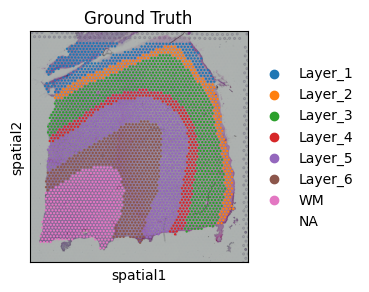

In [13]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


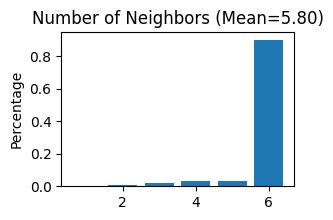

In [14]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=150)
STAGATE.Stats_Spatial_Net(adata)

In [ ]:
adata = STAGATE.train_STAGATE(adata)

Size of Input:  (3460, 3000)


  2%|█▎                                                                              | 17/1000 [00:04<01:37, 10.06it/s]

In [ ]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=7)

In [ ]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' %ARI)

In [ ]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"])

In [ ]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"])